In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as tri
from mpl_toolkits.axes_grid1 import make_axes_locatable
import orthopy,quadpy

As a prime basis, we will start with the hexahedral basis from (Wheeler, Xue & Yotov, 2012) which has a dimension of 24.

In [2]:
def WheelerXueYotov(x,y,z):
    V = np.zeros((3,x.size,24))
    O = np.zeros(x.size)
    for d in range(3):
        V[d,:,4*d+0] = np.ones(x.size)
        V[d,:,4*d+1] = x
        V[d,:,4*d+2] = y
        V[d,:,4*d+3] = z
    V[...,12] = [     x*z,     -y*z,        O] # curl(0       ,0       ,x*y*z   )
    V[...,13] = [   2*x*y,    -y**2,        O] # curl(0       ,0       ,x*y**2  )
    V[...,14] = [       O,   -2*x*z,        O] # curl(0       ,0       ,x**2*z  )
    V[...,15] = [  x**2*z, -2*x*y*z,        O] # curl(0       ,0       ,x**2*y*z)
    V[...,16] = [       O,      x*y,     -x*z] # curl(x*y*z   ,0       ,0       )
    V[...,17] = [       O,    2*y*z,    -z**2] # curl(y*z**2  ,0       ,0       )
    V[...,18] = [       O,        O,   -2*x*y] # curl(x*y**2  ,0       ,0       )
    V[...,19] = [       O,   x*y**2, -2*x*y*z] # curl(x*y**2*z,0       ,0       )
    V[...,20] = [    -x*y,        O,      y*z] # curl(0       ,x*y*z   ,0       )
    V[...,21] = [   -x**2,        O,    2*x*z] # curl(0       ,x**2*z  ,0       )
    V[...,22] = [  -2*y*z,        O,        O] # curl(0       ,y*z**2  ,0       )
    V[...,23] = [-2*x*y*z,        O,   y*z**2] # curl(0       ,x*y*z**2,0       ) 
    return V

We have 4 of 6 constraints for this hexahedral space to restrict it to a prismatic space. Here I will construct a constraint matrix which has these 4 constraints as well as what is needed to remove ${1,x,y}$ on all faces, and $xy$ on the quadilateral faces (the things we want to keep).

In [3]:
def IntegrateFace(Xc,orders,fcns):
    # example: all functions of the first 3 orders
    #   orders = [0,1,1,2,2,2]
    #   fcns   = [0,0,1,0,1,2]
    Xc = np.array(Xc)
    
    if Xc.shape[0] == 3:
        
        # triangle quadrature
        scheme = quadpy.triangle.seven_point()
        quad = scheme.points @ np.asarray([[-1,-1],[+1,-1],[-1,+1]]) # to cartesian
        xq,yq = quad[:,0],quad[:,1]; zq = np.ones(xq.shape)*Xc[0,2]
        wq = scheme.weights
        
        # prime space times outward normal
        P = WheelerXueYotov(xq,yq,zq)
        n = np.cross(Xc[1,:]-Xc[0,:],Xc[2,:]-Xc[0,:]); n = n/np.linalg.norm(n)
        p = P.T @ n 
        
        # compute moments
        bary = np.asarray([(xq+1)/2,(yq+1)/2,1-(xq+1)/2-(yq+1)/2])
        poly = orthopy.triangle.tree(bary,max(orders)+1,"normal")
        I = []
        for o,f in zip(orders,fcns):
            I.append((p*poly[o][f]*wq).sum(axis=1))
        I = np.array(I)

    elif Xc.shape[0] == 4:
        
        # tensor product quadrature
        x1d,w1d = np.polynomial.legendre.leggauss(3)
        x2d,y2d = np.meshgrid(x1d,x1d); x2d = x2d.flatten(); y2d = y2d.flatten()
        w2d = (w1d[:,np.newaxis]*w1d).flatten()
    
        # map 2d quadrature to 3d points on face
        N = 0.25*np.array([(1-x2d)*(1-y2d),
                           (1+x2d)*(1-y2d),
                           (1-x2d)*(1+y2d),
                           (1+x2d)*(1+y2d)])
        Xq = np.dot(Xc.T,N)
        xq  = Xq[0,:]; yq = Xq[1,:]; zq = Xq[2,:]
        dJ = np.linalg.norm(Xc[1,:]-Xc[0,:])*np.linalg.norm(Xc[2,:]-Xc[0,:])/4.0 # if planar

        # prime space times outward normal
        P = WheelerXueYotov(xq,yq,zq)
        n = np.cross(Xc[1,:]-Xc[0,:],Xc[2,:]-Xc[0,:]); n = n/np.linalg.norm(n)
        p = P.T @ n 
    
        # compute moments
        poly = orthopy.quadrilateral.tree(np.asarray([x2d,y2d]),max(orders)+1)
        I = []
        for o,f in zip(orders,fcns):
            I.append((p*poly[o][f]*w2d*dJ).sum(axis=1))
        I = np.array(I)
        
    return I


In [4]:
C =              IntegrateFace([[-1,-1,+1],
                                [+1,-1,+1],
                                [-1,+1,+1]],[0,1,1,2],[0,0,1,0]) # top
C = np.vstack([C,IntegrateFace([[+1,-1,-1],
                                [-1,-1,-1],
                                [-1,+1,-1]],[0,1,1,2],[0,0,1,0])]) # bottom
C = np.vstack([C,IntegrateFace([[-1,-1,-1],
                                [+1,-1,-1],
                                [-1,-1,+1],
                                [+1,-1,+1]],[0,1,1,2],[0,0,1,1])]) # front
C = np.vstack([C,IntegrateFace([[-1,+1,-1],
                                [-1,-1,-1],
                                [-1,+1,+1],
                                [-1,-1,+1]],[0,1,1,2],[0,0,1,1])]) # left
C = np.vstack([C,IntegrateFace([[+1,-1,-1],
                                [-1,+1,-1],
                                [+1,-1,+1],
                                [-1,+1,+1]],[0,1,1,2,2,3],[0,0,1,1,0,1])]) # diagonal

To help visualize what is going on, I will plot the constraint matrix with lines denoting the sections which relate to each face. I also display the singular values and plot the right singular vectors of the null space. Notice that these aren't all zero as we anticipated.

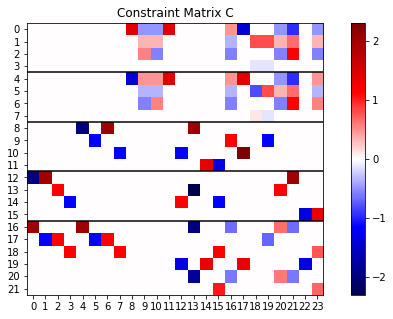

Singular values: [5.25180949 4.08177031 4.00889134 3.03455606 2.90409238 2.72248521
 2.54836936 2.32390967 2.28314677 1.78308871 1.70444182 1.53416903
 1.32217812 1.25436392 1.11159682 0.86697329 0.81791019 0.76263116
 0.69288062 0.64222262 0.07370964 0.07347362]


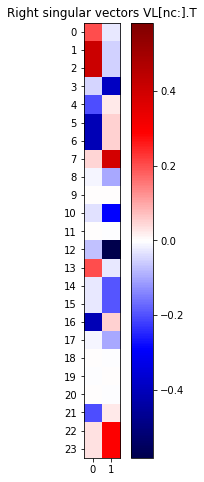

In [5]:
mag = np.abs(C).max()
fig,ax = plt.subplots(figsize=(10,5))
cb = ax.imshow(C,vmin=-mag,vmax=+mag,cmap="seismic")
plt.colorbar(cb)
for i in [3,7,11,15]:
    plt.plot([-0.5,C.shape[1]-0.5],[i+.5,i+.5],'-k')
plt.xlim(-0.5,C.shape[1]-0.5)
plt.xticks(range(C.shape[1]))
plt.yticks(range(C.shape[0]))
plt.title("Constraint Matrix C")
plt.show()

UL,SL,VL = np.linalg.svd(C)
print("Singular values:",SL)

VL = VL[C.shape[0]:,:]
mag = np.abs(VL).max()
fig,ax = plt.subplots(figsize=(4,8))
cb = ax.imshow(VL.T,vmin=-mag,vmax=+mag,cmap="seismic")
plt.colorbar(cb)
plt.xticks(range(VL.shape[0]))
plt.yticks(range(VL.shape[1]))
plt.title("Right singular vectors VL[nc:].T")

plt.show()

Below, I show a quiver plot of these two functions. They look to have 0 trace on the faces, but this is hard to visually confirm. In order to verify that I have correctly removed the terms we want to remove, I also plot the reduced space on each face of the prism and display the maximum and minimum value. This confirms that what I am doing is correct. These are the two functions we have to constrain out of the space.

In [6]:
def CreateTriangleLocations(n):
    u = np.linspace(-1,1,n)
    x,y = np.meshgrid(u,u)
    x = x.flatten(); y = y.flatten()
    ind = np.where(x<(-y)+2/n/10)
    return x[ind],y[ind]

def CreatePrismLocations(n):
    zp = np.linspace(-1,1,n)
    xp,yp = CreateTriangleLocations(n)
    x = xp[:,np.newaxis] * np.ones(zp.size)
    y = yp[:,np.newaxis] * np.ones(zp.size)
    z = np.ones(xp.shape)[:,np.newaxis] * zp
    return x.flatten(order='f'),y.flatten(order='f'),z.flatten(order='f')

In [7]:
xp,yp,zp = CreatePrismLocations(9)
P = WheelerXueYotov(xp,yp,zp)
Pr = VL @ np.swapaxes(P,2,1) # reduced prime basis

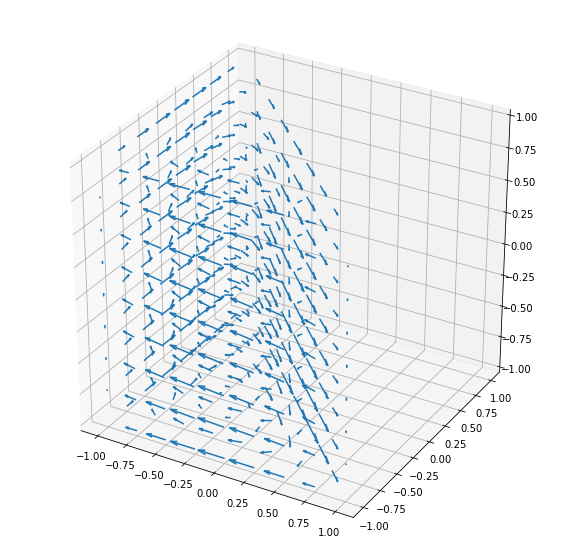

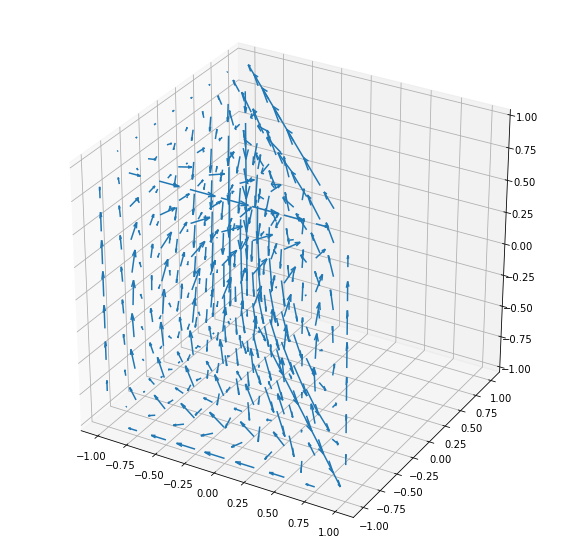

In [8]:
for i in range(Pr.shape[1]):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111,projection='3d')
    ax.quiver(xp,yp,zp,Pr[0,i,:],Pr[1,i,:],Pr[2,i,:])

min/max -2.377e-16 +2.862e-16
min/max -5.204e-16 +5.274e-16
min/max +3.123e-17 +3.747e-16
min/max -8.574e-17 +4.404e-16
min/max -1.397e-15 +4.163e-16
min/max -8.882e-16 +3.886e-16
min/max -7.633e-16 +1.055e-15
min/max -4.441e-16 +4.441e-16
min/max -7.826e-16 +4.218e-16
min/max -4.079e-16 +1.110e-16


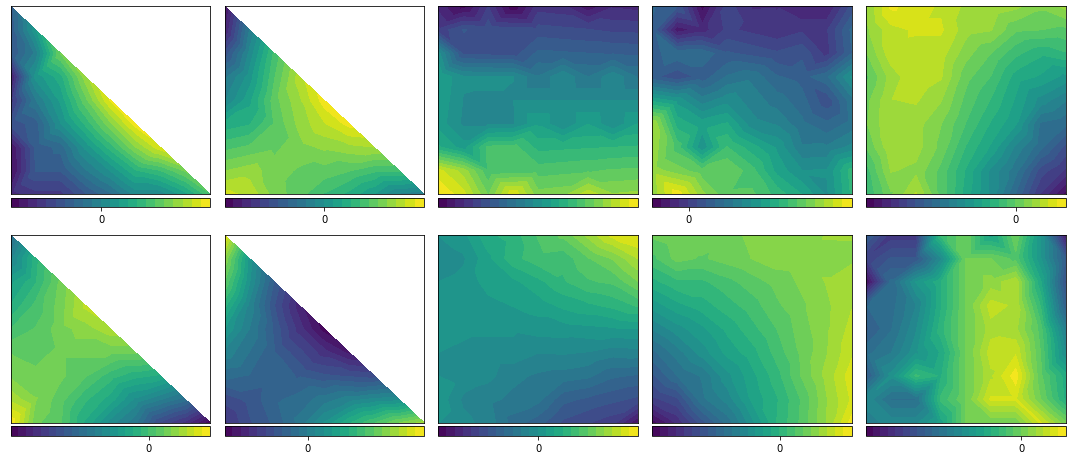

In [9]:
def PlotBasisPlane(condition,x,y,normal,basis,ax):
    ind = np.where(condition)[0]
    T = tri.Triangulation(x[ind],y[ind])
    data = normal @ basis[:,ind]
    print("min/max %+.3e %+.3e" % (data.min(),data.max()))
    p = ax.tricontourf(T,data,25)
    ax.set_xticks([]); ax.set_yticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom',size='5%',pad=0.05)
    plt.colorbar(p,cax=cax,ticks=[0,1],orientation='horizontal')
    
fig,ax = plt.subplots(nrows=Pr.shape[1],ncols=5,tight_layout=True,figsize=(15,6.5))
for i in range(Pr.shape[1]):
    PlotBasisPlane(np.abs(zp-(+1))<1e-3,xp,yp,[ 0, 0,+1],Pr[:,i,:],ax[i,0])
    PlotBasisPlane(np.abs(zp-(-1))<1e-3,xp,yp,[ 0, 0,-1],Pr[:,i,:],ax[i,1])
    PlotBasisPlane(np.abs(xp-(-1))<1e-3,yp,zp,[-1, 0, 0],Pr[:,i,:],ax[i,2])
    PlotBasisPlane(np.abs(yp-(-1))<1e-3,xp,zp,[ 0,-1, 0],Pr[:,i,:],ax[i,3])
    PlotBasisPlane(np.abs(xp+yp  )<1e-3,yp,zp,[+1,+1, 0],Pr[:,i,:],ax[i,4])